In [141]:
## import for plotting
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text

In [149]:
# !pip3 install statannotations
## import for stats
import statsmodels.stats.multitest as smt
from scipy import stats
from collections import defaultdict
from statannotations.Annotator import Annotator

In [79]:
## import for PDB manipulation
from Bio import PDB
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO

### Renumber residues in combined pdb files so the numbers go throughout

In [97]:
def renumber_residues(input_pdb, output_pdb):
    current_residue_number = None
    new_residue_number = 0
    output_lines = []

    with open(input_pdb, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith(("ATOM", "HETATM")):
            # Extract the current residue number (column 6)
            residue_number = int(line[22:26].strip())

            # Check if it's a new residue number
            if residue_number != current_residue_number:
                current_residue_number = residue_number
                new_residue_number += 1

            # Format the new residue number and replace it in the line
            new_line = (line[:22] + f"{new_residue_number:>4}" + line[26:])
            output_lines.append(new_line)
        else:
            output_lines.append(line)

    # Write the modified lines to the output file
    with open(output_pdb, 'w') as file:
        file.writelines(output_lines)

In [98]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/NAD_complex_structure/'

renumber_residues(dir_path + 'complex_I_anoImb_M_N_ddN.pdb', dir_path + 'renum.complex_I_anoImb_M_N_ddN.pdb')
renumber_residues(dir_path + 'complex_I_anoImb_M_N_BEB.pdb', dir_path + 'renum.complex_I_anoImb_M_N_BEB.pdb')

### Compute distance between MT-encoded proteins (chain M) and nuclear-encoded proteins (chain N)

In [62]:
def get_pdb_structure(pdb_file):
    ### Load the PDB file
    
    pdb_parser = PDB.PDBParser(QUIET=True)
    structure = pdb_parser.get_structure('protein', pdb_file)
    return structure

In [63]:
def calculate_distance(coord1, coord2):
    ### Function to calculate distance between two points
    return np.linalg.norm(coord1 - coord2)

In [99]:
pdb_file = 'renum.complex_I_anoImb_M_N_ddN.pdb'
structure = get_pdb_structure(dir_path + pdb_file)


# Select chains M and N
chain_M = structure[0]['M']
chain_N = structure[0]['N']

# Extract CA atoms and their residue IDs for all residues in each chain
ca_atoms_M = [(residue['CA'], f"{residue.resname}_{residue.id[1]}") 
              for residue in chain_M if 'CA' in residue]
ca_atoms_N = [(residue['CA'], f"{residue.resname}_{residue.id[1]}") 
              for residue in chain_N if 'CA' in residue]

# Initialize a distance matrix
distance_matrix = np.zeros((len(ca_atoms_N), len(ca_atoms_M)))

# Fill the matrix with distances and keep track of residue IDs
for i, (atom_N, res_id_N) in enumerate(ca_atoms_N):
    for j, (atom_M, res_id_M) in enumerate(ca_atoms_M):
        distance_matrix[i, j] = calculate_distance(atom_N.coord, atom_M.coord)

# Collect residue IDs for easy reference
residues_M = [res_id_M for _, res_id_M in ca_atoms_M]
residues_N = [res_id_N for _, res_id_N in ca_atoms_N]

# Convert the distance matrix to a pandas DataFrame with residue IDs as row/column labels
distance_df = pd.DataFrame(distance_matrix, index=residues_N, columns=residues_M)
distance_df.head()

,MET_1,THR_2,ASN_3,HIS_4,PRO_5,MET_6,LEU_7,ILE_8,ASN_9,LEU_10,...,GLY_2112,LEU_2113,SER_2114,ARG_2115,GLY_2116,ALA_2117,ILE_2118,ARG_2119,ALA_2120,VAL_2121
MET_2122,55.015274,55.009197,52.996067,51.425522,49.828991,48.470726,46.577038,45.151386,44.115421,42.570705,...,60.545460,58.708694,57.802475,61.152195,63.755150,66.560242,64.517250,62.830669,62.560970,64.053772
TRP_2123,53.039963,53.042133,50.843788,49.352093,47.541759,46.303802,44.590931,42.973400,41.779293,40.470440,...,58.066101,56.393703,55.545761,58.849365,61.387482,64.261116,62.235249,60.710075,60.580334,62.250172
TYR_2124,50.068611,50.226425,48.150162,46.791748,45.124886,44.026363,42.113728,40.424622,39.491623,38.216492,...,59.876221,58.240368,57.605129,60.953564,63.334774,66.148773,63.986702,62.606281,62.402981,64.195854
GLU_2125,49.026562,48.977764,47.018196,45.423580,43.920033,42.553505,40.569477,39.192017,38.259724,36.649460,...,59.211292,57.378174,56.863602,60.324314,62.639919,65.304718,63.002209,61.540691,61.113300,62.813034
ILE_2126,46.746826,46.599575,44.443596,42.827477,41.108440,39.758141,37.992359,36.513149,35.347801,33.884232,...,56.145565,54.414524,54.013912,57.461617,59.675301,62.349182,60.014530,58.697533,58.335915,60.187191


### Get min distance from each nuclear residue to MT residues

In [100]:
min_values_info = []

for row_id, row_data in distance_df.iterrows():
    # Find the column (MT residue) with the minimum value in this row
    min_col = row_data.idxmin()
    min_value = row_data.min()
    min_values_info.append((row_id, min_col, min_value))

min_values_df = pd.DataFrame(min_values_info, columns=['N_Residue', 'Min_M_Residue', 'Min_Distance'])

### Assign ddN (delta dN (Vmac - Aimb)) to each nulear residue

In [101]:
def extract_b_factors(structure, chain_id):
    ### Function to extract the B-factors for the CA atoms in chain M
    
    chain = structure[0][chain_id]
    
    ### Extract B-factors for each residue in the chain (from CA atoms)
    b_factors = {}
    for residue in chain:
        if 'CA' in residue:  # Use CA atoms to be consistent
            res_id = f"{residue.resname}_{residue.id[1]}"
            b_factors[res_id] = residue['CA'].get_bfactor()
    return b_factors

In [102]:
# Extract B-factors for chain N (nuclear residues)
b_factors_M = extract_b_factors(structure, 'N')
min_values_df['ddN'] = min_values_df['N_Residue'].map(b_factors_M)

min_values_df.head()

### Is this AA unique in Aimb? Assign BEB (True or False in this case) values to each nuclear residue

In [107]:
pdb_file = 'renum.complex_I_anoImb_M_N_BEB.pdb'
structure2 = get_pdb_structure(dir_path + pdb_file)

# Extract B-factors for chain N (nuclear residues)
b_factors_M = extract_b_factors(structure2, 'N')
min_values_df['BEB'] = min_values_df['N_Residue'].map(b_factors_M)

### Write table with min distances, ddN, and BEB to a file

In [109]:
min_values_df.to_csv('distances_complex_I_anoImb.tsv', sep='\t', index=False)

### Any correlation between ddN and distance? Yes!

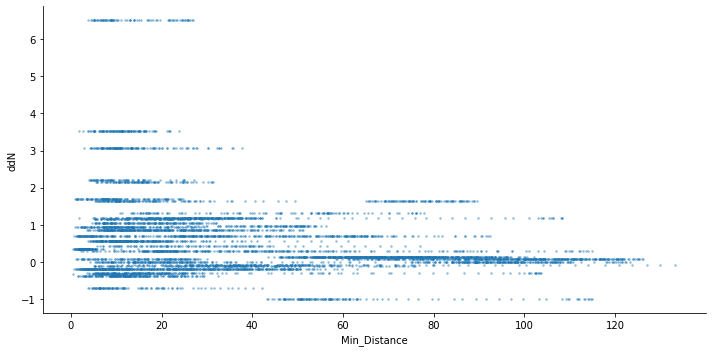

In [114]:
fig, axes = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=min_values_df, x='Min_Distance', y='ddN', linewidth=0, s=6, alpha=0.5)
# axes.set_xlabel('')

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Are sites unique to Aimb more likely to be closer to MT proteins? Yes!

In [135]:
# Get Aimb unique sites and sample the same number of sites from the control (nonunique) sites
beb = min_values_df[min_values_df['BEB'] != 0]
notbeb = min_values_df[min_values_df['BEB'] == 0].sample(n=len(beb))

# Label dataframes and concatenate
beb['selection'] = ['beb']*len(beb)
notbeb['selection'] = ['notbeb']*len(beb)
beb_df = pd.concat([beb, notbeb])


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

beb vs. notbeb: Mann-Whitney-Wilcoxon test two-sided, P_val:2.744e-05 U_stat=6.213e+03


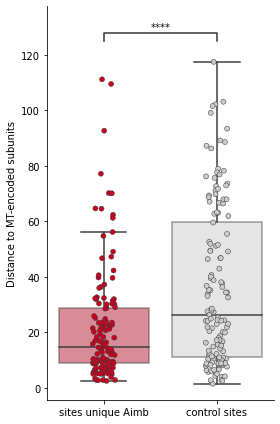

In [160]:
# Plot comparison unique sites vs control
fig, axes = plt.subplots(figsize=(4, 6))
p = ['#ca0020', '#cccccc']
sns.set_palette(p)

sns.boxplot(data=beb_df, y='Min_Distance', x='selection', showfliers=False, boxprops=dict(alpha=0.5))
sns.stripplot(data=beb_df, y='Min_Distance', x='selection', linewidth=0.5)
axes.set_xlabel('')
axes.set_ylabel('Distance to MT-encoded subunits')
axes.set_xticklabels(['sites unique Aimb', 'control sites'])

pairs = [('beb', 'notbeb')]
annotator = Annotator(axes, pairs, data=beb_df, x='selection', y='Min_Distance')
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()